In [1]:
import librosa # for mel-spectrogram estimation
import soundfile # for opening .flac audio
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [8]:
clean_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000.flac')
noisy_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000_noisy.wav')

In [9]:
print(len(clean_audio) / float(framerate)) # length in seconds
print(len(noisy_audio) / float(framerate))

11.85
11.85


In [3]:
# normalized log-mel-spectrogram of clean and noisy audios
clean_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.
noisy_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.

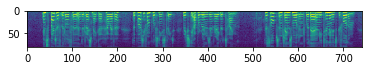

In [4]:
plt.imshow(clean_mel.T)

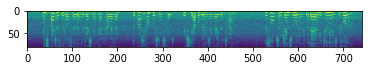

In [5]:
plt.imshow(noisy_mel.T)

In [6]:
clean = np.load('data/train/clean/1006/1006_135212_1006-135212-0011.npy')
noisy = np.load('data/train/noisy/1049/1049_133454_1049-133454-0026.npy')
print(clean.shape)
print(noisy.shape)

(966, 80)
(1031, 80)


In [2]:
import os
def load_train(data_path = 'data/train', size = None, shape = (700, 80), reshape=True):
    noisy_dir = data_path + '/noisy'
    clean_dir = data_path + '/clean'
    noisy_lst = os.listdir(noisy_dir)
    clean_lst = os.listdir(clean_dir)
    if size == None:
        size = max(len(noisy_lst), len(clean_lst))
    data, labels = [], []
    for i in range(len(noisy_lst[:size])):
        path = noisy_dir + '/' + noisy_lst[i]
        files = os.listdir(path)
        for j in range(len(files)):
            mel = np.load(path + '/' + files[j])
            if reshape:
                mel = reshape_mel(mel, shape)
            data.append(mel)
            labels.append(1)
    for i in range(len(clean_lst[:size])):
        path = clean_dir + '/' + clean_lst[i]
        files = os.listdir(path)
        for j in range(len(files)):
            mel = np.load(path + '/' + files[j]).astype('float32')
            if reshape:
                mel = reshape_mel(mel, shape)
            data.append(mel)
            labels.append(0)
    return np.array(data), np.array(labels)
def reshape_mel(mel, shape = (700, 80)):
    if mel.shape[0] > shape[0]:
        diff = mel.shape[0] - shape[0]
        offset = np.random.randint(diff)
        mel = mel[offset:shape[0] + offset, :]
    elif mel.shape[0] < shape[0]:
        diff = shape[0] - mel.shape[0]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((offset, shape[0] - mel.shape[0] - offset), (0, 0)), "constant")
    if mel.shape[1] > shape[1]:
        diff = mel.shape[1] - shape[1]
        offset = np.random.randint(diff)
        mel = mel[:, offset:shape[0] + offset]
    elif mel.shape[1] < shape[1]:
        diff = shape[1] - mel.shape[1]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((0, 0), (offset, shape[0] - mel.shape[0] - offset)), "constant")
    return mel
    

In [3]:
X, y = load_train(100)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [50]:
print(data.shape)
print(y.shape)

(1616,)
(1616,)


In [51]:
X[0].shape

(500, 80)

In [96]:
print(np.min(X), np.max(X))

-1.7626953 1.7509766


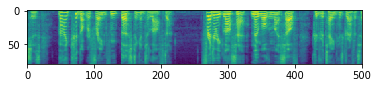

In [60]:
plt.imshow(X[1356].T)

In [13]:
data, y = load_train(size=1000, reshape=False)
counts = np.unique(list(map(lambda x: x.shape[0], data)), return_counts=True)
counts_h = np.unique(list(map(lambda x: x.shape[1], data)), return_counts=True)
counts_y = np.unique(y, return_counts=True)

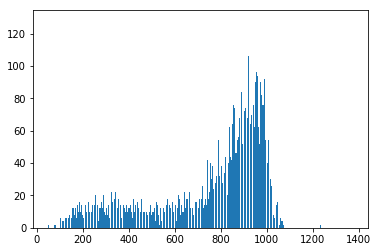

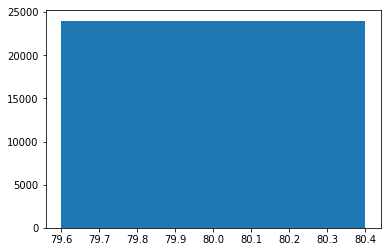

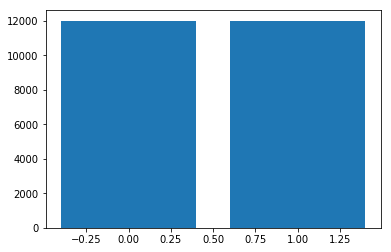

In [14]:
plt.bar(counts[0], counts[1]);
plt.show()
plt.bar(counts_h[0], counts_h[1]);
plt.show()
plt.bar(counts_y[0], counts_y[1]);

In [94]:
print(np.median(counts[0]), np.median(counts_h[0]))

697.0 80.0


Label: clean


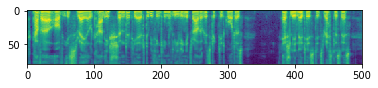

In [106]:
idx = 234
plt.imshow(X[idx].T);
print('Label: ' + ('noisy' if y[idx] == 1 else 'clean'))

In [3]:
import torch
import numpy as np
class NoiseDetector(torch.nn.Module):
    def __init__(self):
        super(NoiseDetector, self).__init__()
        input_shape = (200, 80)
        self.input_shape = input_shape
        self.conv1 = torch.nn.Conv2d(1, 15, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1)
        self.conv2 = torch.nn.Conv2d(15, 15, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1)
        self.linsize = (self.input_shape[0] - 2) * (self.input_shape[1] - 2)
        self.fc1 = torch.nn.Linear(15 * self.linsize, 20)
        self.dropout = torch.nn.Dropout(0.4)
        self.fc2 = torch.nn.Linear(20, 1)
        self.act = torch.nn.Sigmoid()
    def forward(self, input):
        out = self.conv1(input)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = out.view(-1, 15 * self.linsize)#int(self.input_shape[0] * self.input_shape[1] / 16))#int(np.prod(out.shape[1:])))
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.act(out)
        return out
        

In [25]:
from torch import nn
from torch.autograd import Variable 
from torch.optim import Adam

In [3]:
model = NoiseDetector()


In [4]:
import os
def batch_iterator(batch_size, data_path, shape):
    noisy_dir = data_path + '/noisy'
    clean_dir = data_path + '/clean'
    noisy_lst = os.listdir(noisy_dir)
    clean_lst = os.listdir(clean_dir)
    size = max(len(noisy_lst), len(clean_lst))
    data, labels = [], []
    for i in range(len(noisy_lst[:size])):
        path = noisy_dir + '/' + noisy_lst[i]
        files = os.listdir(path)
        for j in range(len(files)):
            data.append(path + '/' + files[j])
            labels.append(1)
    for i in range(len(clean_lst[:size])):
        path = clean_dir + '/' + clean_lst[i]
        files = os.listdir(path)
        for j in range(len(files)):
            data.append(path + '/' + files[j])
            labels.append(0)
    data, labels = np.array(data), np.array(labels)
    idx = np.array(range(len(data)))
    np.random.shuffle(idx)
    for i in range(0, len(idx), batch_size):
        x = np.stack([reshape_mel(np.load(data[idx[j]]), shape).astype('float32')[None] for j in range(i, min(i + batch_size, len(data)))], 0)
        y = np.stack([labels[idx[j]] for j in range(i, min(i + batch_size, len(data)))], 0)
        yield x, y
    
def reshape_mel(mel, shape = (80, 80)):
    if mel.shape[0] > shape[0]:
        diff = mel.shape[0] - shape[0]
        offset = np.random.randint(diff)
        mel = mel[offset:shape[0] + offset, :]
    elif mel.shape[0] < shape[0]:
        diff = shape[0] - mel.shape[0]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((offset, shape[0] - mel.shape[0] - offset), (0, 0)), "constant")
    if mel.shape[1] > shape[1]:
        diff = mel.shape[1] - shape[1]
        offset = np.random.randint(diff)
        mel = mel[:, offset:shape[1] + offset]
    elif mel.shape[1] < shape[1]:
        diff = shape[1] - mel.shape[1]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((0, 0), (offset, shape[1] - mel.shape[1] - offset)), "constant")
    return mel

In [26]:
def train(net, path, batch_size = 100, n_epochs = 30, lr = 1e-3):
    optimizer = Adam(net.parameters(), lr=lr)
    loss = torch.nn.BCELoss()
    for i in range(n_epochs):
        sum_loss = 0
        for x, y in batch_iterator(batch_size=batch_size, data_path=path, shape=net.input_shape):
            x = Variable(torch.Tensor(x)).cuda()
            y = Variable(torch.Tensor(y).long()).cuda()
            optimizer.zero_grad()
            output = net(x)
            loss_out = loss(output, y)
            loss_out.backward()
            optimizer.step()
            sum_loss += loss_out.data[0]
        if i % 10 == 0 and i > 0:
            print("EPOCH #" + str(i))
            print("Loss: " + str(sum_loss))
            torch.save(net, 'trained/cnn_epoch' + str(i) + '.pth')
    torch.save(net, 'trained/cnn.pth')
    

In [6]:
model = NoiseDetector().cuda()
train(model, 'data/train')

EPOCH #10
Loss: 0.0


C:\Users\mi\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type NoiseDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


EPOCH #20
Loss: -1.000000013351432e-10


In [23]:
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.autograd import Variable
def validate(model_path, data_path):
    model = torch.load(model_path).cpu()
    for x, y in batch_iterator(batch_size=200, data_path=data_path, shape=model.input_shape):
        x = Variable(torch.Tensor(x))
        x = np.array(list(map(lambda x: 1 if x > 0.5 else 0, model(x).data.numpy())))
        print(x)
        print('Accuracy: ' + str(accuracy_score(y, x)))

In [3]:
import validator
from model import NoiseDetector

In [4]:
import validator
from model import NoiseDetector
validator.validate('trained/cnn.pth', 'data/val')

0.49725

In [1]:
from trainer import train
from model import NoiseDetector

In [3]:
model = NoiseDetector().cuda()
train(model, 'data/train')

C:\Users\mi\Anaconda3\lib\site-packages\torch\nn\functional.py:1189: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\mi\Anaconda3\lib\site-packages\torch\nn\functional.py:1189: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


EPOCH #10
Loss: 35.09139668941498


KeyboardInterrupt: 